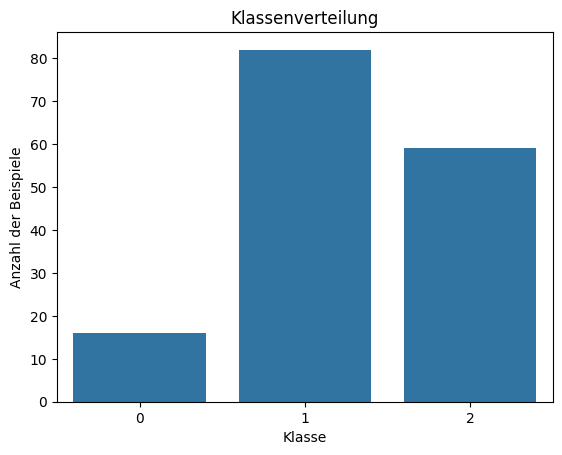

Klassen-Gewichte: {0: np.float64(2.9761904761904763), 1: np.float64(0.6720430107526881), 2: np.float64(0.8503401360544217)}
Angepasste Klassen-Gewichte: {0: np.float64(5.9523809523809526), 1: np.float64(0.6720430107526881), 2: np.float64(0.8503401360544217)}
Epoch 1/20


C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.2237 - loss: 1.5641 - val_accuracy: 0.0625 - val_loss: 1.1395
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.1778 - loss: 1.4544 - val_accuracy: 0.0625 - val_loss: 1.1531
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.2237 - loss: 1.4417 - val_accuracy: 0.0938 - val_loss: 1.1758
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.1735 - loss: 1.3189 - val_accuracy: 0.1250 - val_loss: 1.1911
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.1704 - loss: 1.3942 - val_accuracy: 0.1250 - val_loss: 1.2224
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.1661 - loss: 1.2808 - val_accuracy: 0.1250 - val_loss: 1.2080
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.2034 - loss: 1.1753 - val_accuracy: 0.1875 - val_loss: 2.5122
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.3994 - loss: 1.3289 - val_accuracy: 0.6250 - val_loss: 0.9613
Epo

C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarnin

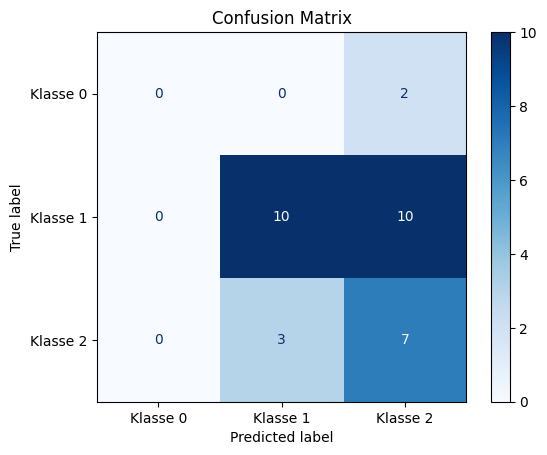

In [6]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
#from tensorflow.keras.utils import class_weight


# Helper functions
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids


def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Class', 'Age', 'Converted-MMSE']]

# Load and preprocess data
base_path = "../process/PROCESS-V1/"
file_pattern = r"Process-rec-\d+__CTD\.txt"
data, record_ids = load_data(file_pattern, base_path)

label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

combined_data = []
for text, record_id in zip(data, record_ids):
    if record_id in labels.index:
        row = labels.loc[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'Text': text,
            'Class': row['Class'],
            'Age': row['Age'],
            'Converted-MMSE': row['Converted-MMSE'],
        })

df = pd.DataFrame(combined_data)
df['Class'] = LabelEncoder().fit_transform(df['Class'])
df.dropna(inplace=True)

# Klassenverteilung analysieren
class_counts = df['Class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Klassenverteilung")
plt.xlabel("Klasse")
plt.ylabel("Anzahl der Beispiele")
plt.show()

# Textdaten Tokenisierung und Padding
MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LENGTH = 200
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['Text'])
X_text = tokenizer.texts_to_sequences(df['Text'])
X_text = pad_sequences(X_text, maxlen=MAX_SEQUENCE_LENGTH)

# Numerische Daten skalieren
X_numeric = df[['Age', 'Converted-MMSE']].values
scaler = MinMaxScaler()
X_numeric = scaler.fit_transform(X_numeric)

y = to_categorical(df['Class'])

# Daten aufteilen
X_train_text, X_test_text, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))
print("Klassen-Gewichte:", class_weights)

class_weights[0] *= 2  # Erhöhen Sie das Gewicht von Klasse 0
print("Angepasste Klassen-Gewichte:", class_weights)

# LSTM-Modell definieren
embedding_dim = 128

# Text-Eingabe
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
embedding = Embedding(MAX_NUM_WORDS, embedding_dim, input_length=MAX_SEQUENCE_LENGTH)(text_input)
lstm = LSTM(128, return_sequences=False)(embedding)
text_output = Dropout(0.5)(lstm)

# Numerische Eingabe
numeric_input = Input(shape=(X_numeric.shape[1],), name='numeric_input')
numeric_output = Dense(64, activation='relu')(numeric_input)

# Kombination von Text- und numerischen Eingaben
combined = Concatenate()([text_output, numeric_output])
dense1 = Dense(128, activation='relu')(combined)
dropout = Dropout(0.5)(dense1)
output = Dense(y.shape[1], activation='softmax')(dropout)

model = Model(inputs=[text_input, numeric_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modell trainieren
history = model.fit(
    [X_train_text, X_train_numeric], y_train,
    validation_data=([X_test_text, X_test_numeric], y_test),
    class_weight=class_weights,
    epochs=20,
    batch_size=32
)

# Modell auswerten
y_pred_prob = model.predict([X_test_text, X_test_numeric])
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
class_names = ['Klasse 0', 'Klasse 1', 'Klasse 2']  # Ersetzen Sie durch tatsächliche Klassen
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
